# Generate training samples for VQ-VAE

This notebook geneerate training samples (batch size = 1) for VQ-VAE.
* All samples, including testing set samples were generated.
* Samples were saved as .npy files; their file names contain the datetime information, so the testing samplles will not be touched.

In [1]:
import os
import sys
import time
import h5py
import numpy as np
from glob import glob

# ------------------------------------------------------- #
# Turn-off warnings
import logging
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# ------------------------------------------------------- #
# Turn-off tensoflow-specific warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# ------------------------------------------------------- #
# Import customized modules and settings
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# VQ-VAE backbone

In [3]:
# Hyperparameters
filter_nums = [64, 128] # number of convolution kernels per down-/upsampling layer 
latent_dim = 4 # number of latent feature channels
activation = 'gelu' # activation function
num_embeddings = 128 #128 # number of the VQ codes

input_size = (224, 464, 1) # size of MRMS input
latent_size = (14, 29, latent_dim) # size of compressed latent features

drop_encode = False
drop_decode = False

model_name_encoder_load = model_dir+'models/VQ_VAE_encoder_stack1_tune0'
model_name_decoder_load = model_dir+'models/VQ_VAE_decoder_stack1_tune0'

encoder = mu.VQ_VAE_encoder(input_size, filter_nums, latent_dim, num_embeddings, activation, drop_encode)

W_old = mu.dummy_loader(model_name_encoder_load)
encoder.set_weights(W_old)

decoder = mu.VQ_VAE_decoder(latent_size, filter_nums, activation, drop_decode)

W_old = mu.dummy_loader(model_name_decoder_load)
decoder.set_weights(W_old)

In [4]:
# Connect the encoder and decoder
X = keras.Input(shape=input_size)
X_encode = encoder(X)
X_decode = decoder(X_encode)
VQ_VAE = keras.Model(X, X_decode)

## Generate training samples

* Locations: `$camp_dir+BATCH_dscale/`
* Normalization:
```python
apcp = np.log(0.1*apcp+1)
```

In [5]:
def norm_precip(x):
    return np.log(0.1*x+1)

def norm_elev(x):
    return x / np.nanmax(x)

In [6]:
with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
    land_mask_CCPA = h5io['land_mask_CCPA'][...]
    elev_CCPA = h5io['elev_CCPA'][...]
    
land_mask = land_mask_CCPA == 1.0
ocean_mask = land_mask_CCPA == 0.0
grid_shape = land_mask.shape

elev_CCPA[ocean_mask] = 0
elev_CCPA[elev_CCPA<0] = 0
elev_CCPA = norm_elev(elev_CCPA)

In [7]:
with h5py.File(camp_dir+'CCPA/CCPA_CDFs_2002_2019.hdf', 'r') as h5io:
    CCPA_CDFs = h5io['CCPA_CDFs'][...]
CCPA_CDFs_99 = norm_precip(CCPA_CDFs[99, ...])
CCPA_CDFs_99[ocean_mask, :] = 0

In [1]:
BATCH_dir = camp_dir+'BATCH_dscale/'
batch_name = 'CCPA_y{}_d{:03d}_h{}.npy' #.format(datetime, hour-of-day)

filename_ccpa = camp_dir+'CCPA/CCPA_y{}.hdf'
batch_save = np.empty(grid_shape+(4,))

for year in range(2002, 2022):
    print('Batch gen year: {}'.format(year))
    
    with h5py.File(filename_ccpa.format(year), 'r') as h5io:
        CCPA = h5io['CCPA'][...]
        
    N_days = len(CCPA)
    
    for i6hour in range(4):
        CCPA_input = norm_precip(CCPA[:, i6hour, ...])
        CCPA_input[:, ocean_mask] = 0.0
        
        CCPA_VAE = VQ_VAE.predict(CCPA_input[..., None], verbose=0)[..., 0]
        CCPA_VAE[CCPA_VAE<0] = 0
        CCPA_VAE[:, ocean_mask] = 0
        
        CCPA_CDFs_99_ = CCPA_CDFs_99[..., i6hour]
        for iday in range(N_days):
            batch_save[...] = np.nan
            batch_save[..., 0] = CCPA_VAE[iday, ...]
            batch_save[..., 1] = elev_CCPA
            batch_save[..., 2] = CCPA_CDFs_99_
            batch_save[..., 3] = CCPA_input[iday, ...]

            save_name = BATCH_dir+batch_name.format(year, iday, i6hour)
            if np.sum(np.isnan(batch_save)) > 0:
                print('NaNs --> {}'.format(save_name))
            else:
                # print(save_name)
                np.save(save_name, batch_save)

### Check batch quality

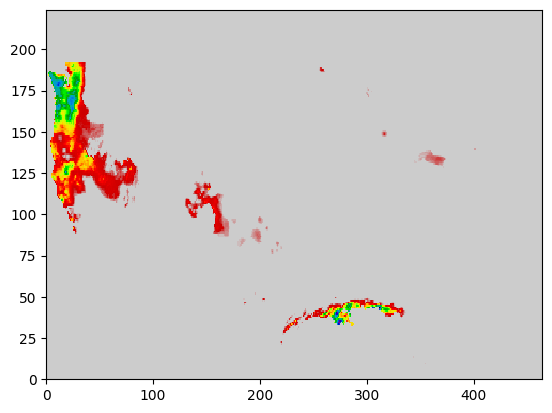

In [61]:
plt.pcolormesh(batch_save[..., 3], cmap=plt.cm.nipy_spectral_r)